In [20]:
import os
import re
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [21]:
# Defining the base dataset directory
base_dir = "dataset"

# Patterns for matching file names for B2/B3 and B4
filename_pattern_b2_b3 = re.compile(r"(\d+)_([a-zA-Z]+)_([\d.]+)_(\w)\.\w+")
filename_pattern_b4 = re.compile(r"(\d+)_(\d+)-(\d+)_([a-zA-Z]+)_([\d.]+)_(\w)\.\w+")

images = []
weights = []

# Extracting image paths and corresponding weights
for root, dirs, files in os.walk(base_dir):
    for file in files:
        # Check if the file is an image (you can add other extensions if needed)
        if file.endswith(('.jpg', '.png', '.jpeg')):
            file_path = os.path.join(root, file)

            # Match file names for B2/B3 or B4
            match_b2_b3 = filename_pattern_b2_b3.match(file)
            match_b4 = filename_pattern_b4.match(file)

            if match_b2_b3:
                # Extract info for B2/B3
                image_id, side_or_rear, weight, sex = match_b2_b3.groups()
                images.append(file_path)
                weights.append(float(weight))

            elif match_b4:
                # Extract info for B4
                image_id, batch_id, subbatch_id, side_or_rear, weight, sex = match_b4.groups()
                images.append(file_path)
                weights.append(float(weight))

# Checking if data was loaded
print(f"Number of images found: {len(images)}")
print(f"Number of weights extracted: {len(weights)}")

if len(images) == 0 or len(weights) == 0:
    print("No images or weights found. Please check the folder path and file patterns.")

Number of images found: 11553
Number of weights extracted: 11553


In [22]:
def load_images(image_paths):
    """Load and preprocess images from given paths."""
    image_data = []
    for path in image_paths:
        # Load image and resize to a standard size (e.g., 224x224)
        img = load_img(path, target_size=(224, 224))
        img_array = img_to_array(img)
        image_data.append(img_array)
    return np.array(image_data)


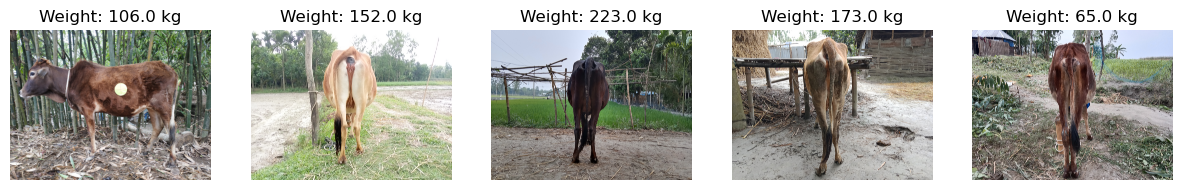

In [23]:
# Function to display sampleimages with their corresponding weights
def visualize_cattle(images, weights, num_samples=5):
    # Select a few samples for visualization
    selected_indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(selected_indices):
        img_path = images[idx]
        img = cv2.imread(img_path)  # Load image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Weight: {weights[idx]} kg")
        plt.axis('off')

    plt.show()

# Visualize some cattle images and their weights
visualize_cattle(images, weights, num_samples=5)


In [24]:
def regression_model():
    """Regression model for weight prediction with data augmentation, reduced complexity, and regularization."""
    image_input = layers.Input(shape=(224, 224, 3))

    # Simplified CNN architecture with L2 regularization and Batch Normalization
    z = layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.03))(image_input)
    z = layers.BatchNormalization()(z)
    z = layers.MaxPooling2D((2, 2))(z)
    
    z = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.03))(z)
    z = layers.BatchNormalization()(z)
    z = layers.MaxPooling2D((2, 2))(z)

    z = layers.Flatten()(z)
    z = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03))(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.6)(z)  # Increased dropout
    z = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.03))(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.6)(z)
    z = layers.Dense(1, activation='linear')(z)

    model = models.Model(inputs=image_input, outputs=z)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Adjusted learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    return initial_lr * (0.1 ** (epoch // 20))

X = load_images(images)  # Using your existing load_images function
y = np.array(weights)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Enhanced data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

# Initialize the model
model = regression_model()

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=100,  # Increased epochs, early stopping will prevent overfitting
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")


Training set size: 9242
Test set size: 2311


C:\Users\ELITEBOOK\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - loss: 26842.3184 - mae: 156.9398 - val_loss: 26196.4453 - val_mae: 154.3044 - learning_rate: 0.0010
Epoch 2/100
  1/288 ━━━━━━━━━━━━━━━━━━━━ 3:13 673ms/step - loss: 22326.9277 - mae: 144.5619

C:\Users\ELITEBOOK\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 22326.9277 - mae: 144.5619 - val_loss: 26173.6738 - val_mae: 154.2303 - learning_rate: 0.0010
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1241s 4s/step - loss: 24775.8145 - mae: 150.2355 - val_loss: 21299.7676 - val_mae: 137.5257 - learning_rate: 0.0010
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 19624.0977 - mae: 133.5315 - val_loss: 21326.8887 - val_mae: 137.6255 - learning_rate: 0.0010
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1105s 4s/step - loss: 20160.7480 - mae: 133.5378 - val_loss: 17403.5273 - val_mae: 122.4622 - learning_rate: 0.0010
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 12624.8076 - mae: 102.2512 - val_loss: 17322.7070 - val_mae: 122.1306 - learning_rate: 0.0010
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 941s 3s/step - loss: 14196.5596 - mae: 108.2268 - val_loss: 11423.8418 - val_mae: 94.8554 - learning_rate: 0.0010
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 12662.469

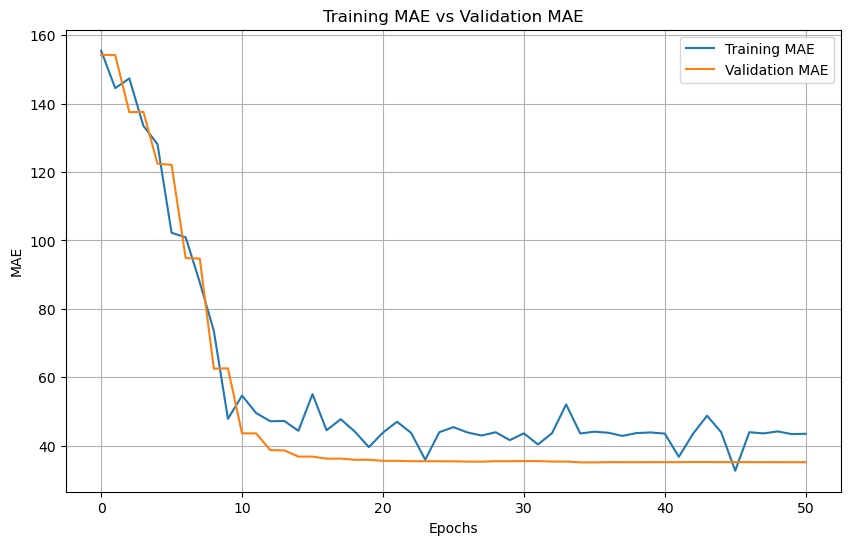

In [25]:
def plot_mae_vs_val_mae(history):
    plt.figure(figsize=(10, 6))

    # Plot training MAE
    plt.plot(history.history['mae'], label='Training MAE')

    # Plot validation MAE
    plt.plot(history.history['val_mae'], label='Validation MAE')

    plt.title('Training MAE vs Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
plot_mae_vs_val_mae(history)

In [ ]:
# Save the final model (optional)
model.save('cattle_weight_prediction_model_mobilenetv3large.h5')